# 11.1. Optimization and Deep Learning

### Goal of Optimization

In [ ]:
!pip install d2l

In [2]:
%matplotlib inline
import numpy as np
import torch
from mpl_toolkits import mplot3d
from d2l import torch as d2l

In [3]:
def f(x):
    return x * torch.cos(np.pi * x)

def g(x):
    return f(x) + 0.2 * torch.cos(5 * np.pi * x)

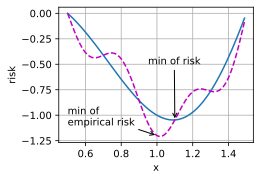

In [4]:
def annotate(text, xy, xytext):  #@save
    d2l.plt.gca().annotate(text, xy=xy, xytext=xytext,
                           arrowprops=dict(arrowstyle='->'))

x = torch.arange(0.5, 1.5, 0.01)
d2l.set_figsize((4.5, 2.5))
d2l.plot(x, [f(x), g(x)], 'x', 'risk')
annotate('min of\nempirical risk', (1.0, -1.2), (0.5, -1.1))
annotate('min of risk', (1.1, -1.05), (0.95, -0.5))

### Local Minima

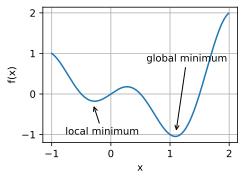

In [5]:
x = torch.arange(-1.0, 2.0, 0.01)
d2l.plot(x, [f(x), ], 'x', 'f(x)')
annotate('local minimum', (-0.3, -0.25), (-0.77, -1.0))
annotate('global minimum', (1.1, -0.95), (0.6, 0.8))

### Saddle Points

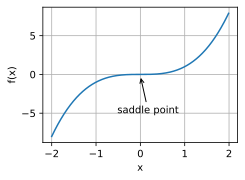

In [6]:
x = torch.arange(-2.0, 2.0, 0.01)
d2l.plot(x, [x**3], 'x', 'f(x)')
annotate('saddle point', (0, -0.2), (-0.52, -5.0))

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


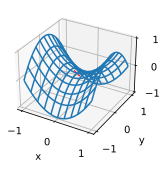

In [7]:
x, y = torch.meshgrid(
    torch.linspace(-1.0, 1.0, 101), torch.linspace(-1.0, 1.0, 101))
z = x**2 - y**2

ax = d2l.plt.figure().add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, **{'rstride': 10, 'cstride': 10})
ax.plot([0], [0], [0], 'rx')
ticks = [-1, 0, 1]
d2l.plt.xticks(ticks)
d2l.plt.yticks(ticks)
ax.set_zticks(ticks)
d2l.plt.xlabel('x')
d2l.plt.ylabel('y');

### Vanishing Gradients

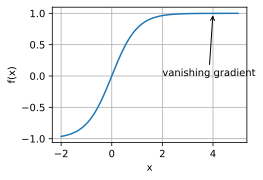

In [8]:
x = torch.arange(-2.0, 5.0, 0.01)
d2l.plot(x, [torch.tanh(x)], 'x', 'f(x)')
annotate('vanishing gradient', (4, 1), (2, 0.0))

### Summary

- Minimizing the training error does not guarantee that we find the best set of parameters to minimize the generalization error.

- The optimization problems may have many local minima.

- The problem may have even more saddle points, as generally the problems are not convex.

- Vanishing gradients can cause optimization to stall. Often a reparameterization of the problem helps. Good initialization of the parameters can be beneficial, too.

# 11.2. Convexity

### Convex Functions

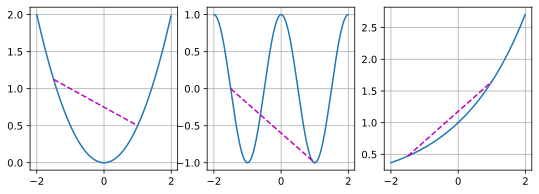

In [9]:
f = lambda x: 0.5 * x**2  # Convex
g = lambda x: torch.cos(np.pi * x)  # Nonconvex
h = lambda x: torch.exp(0.5 * x)  # Convex

x, segment = torch.arange(-2, 2, 0.01), torch.tensor([-1.5, 1])
d2l.use_svg_display()
_, axes = d2l.plt.subplots(1, 3, figsize=(9, 3))
for ax, func in zip(axes, [f, g, h]):
    d2l.plot([x, segment], [func(x), func(segment)], axes=ax)

### Local Minima Are Global Minima

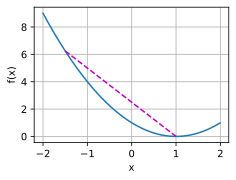

In [10]:
f = lambda x: (x - 1) ** 2
d2l.set_figsize()
d2l.plot([x, segment], [f(x), f(segment)], 'x', 'f(x)')

### Summary

- In the context of deep learning the main purpose of convex functions is to motivate optimization algorithms and help us understand them in detail. In the following we will see how gradient descent and stochastic gradient descent can be derived accordingly.

- Intersections of convex sets are convex. Unions are not.

- The expectation of a convex function is no less than the convex function of an expectation (Jensen’s inequality).

- A twice-differentiable function is convex if and only if its Hessian (a matrix of second derivatives) is positive semidefinite.

- Convex constraints can be added via the Lagrangian. In practice we may simply add them with a penalty to the objective function.

- Projections map to points in the convex set closest to the original points.

# 11.3. Gradient Descent

### One-Dimensional Gradient Descent

In [11]:
def f(x):  # Objective function
    return x ** 2

def f_grad(x):  # Gradient (derivative) of the objective function
    return 2 * x

In [12]:
def gd(eta, f_grad):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * f_grad(x)
        results.append(float(x))
    print(f'epoch 10, x: {x:f}')
    return results

results = gd(0.2, f_grad)

epoch 10, x: 0.060466


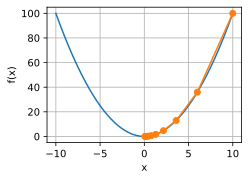

In [13]:
def show_trace(results, f):
    n = max(abs(min(results)), abs(max(results)))
    f_line = torch.arange(-n, n, 0.01)
    d2l.set_figsize()
    d2l.plot([f_line, results], [[f(x) for x in f_line], [
        f(x) for x in results]], 'x', 'f(x)', fmts=['-', '-o'])

show_trace(results, f)

### Learning Rate

epoch 10, x: 3.486784


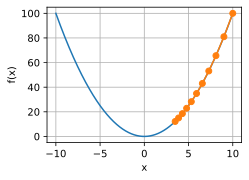

In [14]:
show_trace(gd(0.05, f_grad), f)

epoch 10, x: 61.917364


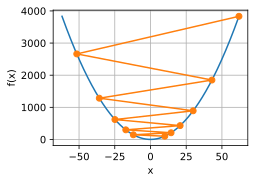

In [15]:
show_trace(gd(1.1, f_grad), f)

### Local Minima

epoch 10, x: -1.528166


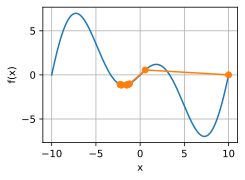

In [16]:
c = torch.tensor(0.15 * np.pi)

def f(x):  # Objective function
    return x * torch.cos(c * x)

def f_grad(x):  # Gradient of the objective function
    return torch.cos(c * x) - c * x * torch.sin(c * x)

show_trace(gd(2, f_grad), f)

### Multivariate Gradient Descent

In [17]:
def train_2d(trainer, steps=20, f_grad=None):  #@save
    """Optimize a 2D objective function with a customized trainer."""
    # `s1` and `s2` are internal state variables that will be used later
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(steps):
        if f_grad:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2, f_grad)
        else:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print(f'epoch {i + 1}, x1: {float(x1):f}, x2: {float(x2):f}')
    return results

In [18]:
def show_trace_2d(f, results):  #@save
    """Show the trace of 2D variables during optimization."""
    d2l.set_figsize()
    d2l.plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = torch.meshgrid(torch.arange(-5.5, 1.0, 0.1),
                          torch.arange(-3.0, 1.0, 0.1))
    d2l.plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    d2l.plt.xlabel('x1')
    d2l.plt.ylabel('x2')

epoch 20, x1: -0.057646, x2: -0.000073


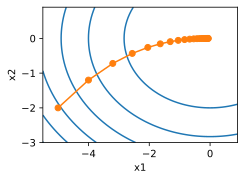

In [19]:
def f_2d(x1, x2):  # Objective function
    return x1 ** 2 + 2 * x2 ** 2

def f_2d_grad(x1, x2):  # Gradient of the objective function
    return (2 * x1, 4 * x2)

def gd_2d(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    return (x1 - eta * g1, x2 - eta * g2, 0, 0)

eta = 0.1
show_trace_2d(f_2d, train_2d(gd_2d, f_grad=f_2d_grad))

### Newton’s Method

epoch 10, x: tensor(0.)


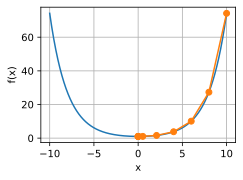

In [20]:
c = torch.tensor(0.5)

def f(x):  # Objective function
    return torch.cosh(c * x)

def f_grad(x):  # Gradient of the objective function
    return c * torch.sinh(c * x)

def f_hess(x):  # Hessian of the objective function
    return c**2 * torch.cosh(c * x)

def newton(eta=1):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * f_grad(x) / f_hess(x)
        results.append(float(x))
    print('epoch 10, x:', x)
    return results

show_trace(newton(), f)

epoch 10, x: tensor(26.8341)


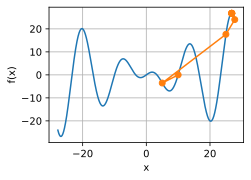

In [21]:
c = torch.tensor(0.15 * np.pi)

def f(x):  # Objective function
    return x * torch.cos(c * x)

def f_grad(x):  # Gradient of the objective function
    return torch.cos(c * x) - c * x * torch.sin(c * x)

def f_hess(x):  # Hessian of the objective function
    return - 2 * c * torch.sin(c * x) - x * c**2 * torch.cos(c * x)

show_trace(newton(), f)

epoch 10, x: tensor(7.2699)


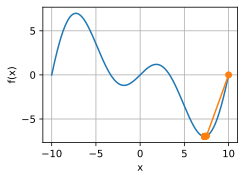

In [22]:
show_trace(newton(0.5), f)

### Summary

- Learning rates matter. Too large and we diverge, too small and we do not make progress.

- Gradient descent can get stuck in local minima.

- In high dimensions adjusting the learning rate is complicated.

- Preconditioning can help with scale adjustment.

- Newton’s method is a lot faster once it has started working properly in convex problems.

- Beware of using Newton’s method without any adjustments for nonconvex problems.

# 11.4. Stochastic Gradient Descent

In [ ]:
pip install mxnet

In [26]:
%matplotlib inline
import math
from mxnet import np, npx
from d2l import mxnet as d2l

npx.set_np()

### Stochastic Gradient Updates

epoch 50, x1: -0.100155, x2: -0.005702


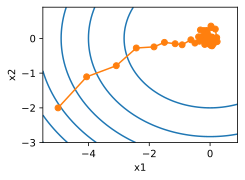

In [27]:
def f(x1, x2):  # Objective function
    return x1 ** 2 + 2 * x2 ** 2

def f_grad(x1, x2):  # Gradient of the objective function
    return 2 * x1, 4 * x2

def sgd(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    # Simulate noisy gradient
    g1 += torch.normal(0.0, 1, (1,))
    g2 += torch.normal(0.0, 1, (1,))
    eta_t = eta * lr()
    return (x1 - eta_t * g1, x2 - eta_t * g2, 0, 0)

def constant_lr():
    return 1

eta = 0.1
lr = constant_lr  # Constant learning rate
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50, f_grad=f_grad))

### Dynamic Learning Rate

epoch 1000, x1: -0.654385, x2: -0.025375


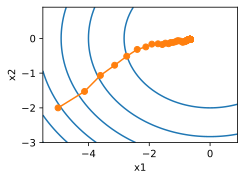

In [28]:
def exponential_lr():
    # Global variable that is defined outside this function and updated inside
    global t
    t += 1
    return math.exp(-0.1 * t)

t = 1
lr = exponential_lr
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=1000, f_grad=f_grad))

epoch 50, x1: -0.079894, x2: -0.048091


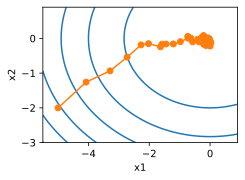

In [29]:
def polynomial_lr():
    # Global variable that is defined outside this function and updated inside
    global t
    t += 1
    return (1 + 0.1 * t) ** (-0.5)

t = 1
lr = polynomial_lr
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50, f_grad=f_grad))

### Summary

- For convex problems we can prove that for a wide choice of learning rates stochastic gradient descent will converge to the optimal solution.

- For deep learning this is generally not the case. However, the analysis of convex problems gives us useful insight into how to approach optimization, namely to reduce the learning rate progressively, albeit not too quickly.

- Problems occur when the learning rate is too small or too large. In practice a suitable learning rate is often found only after multiple experiments.

- When there are more examples in the training dataset, it costs more to compute each iteration for gradient descent, so stochastic gradient descent is preferred in these cases.

- Optimality guarantees for stochastic gradient descent are in general not available in nonconvex cases since the number of local minima that require checking might well be exponential.

# 11.5. Minibatch Stochastic Gradient Descent

### Vectorization and Caches

In [30]:
%matplotlib inline
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

timer = d2l.Timer()
A = torch.zeros(256, 256)
B = torch.randn(256, 256)
C = torch.randn(256, 256)

In [31]:
# Compute A = BC one element at a time
timer.start()
for i in range(256):
    for j in range(256):
        A[i, j] = torch.dot(B[i, :], C[:, j])
timer.stop()

0.9496889114379883

In [32]:
# Compute A = BC one column at a time
timer.start()
for j in range(256):
    A[:, j] = torch.mv(B, C[:, j])
timer.stop()

0.02259206771850586

In [33]:
# Compute A = BC one column at a time
timer.start()
for j in range(256):
    A[:, j] = torch.mv(B, C[:, j])
timer.stop()

0.011391878128051758

### Minibatches

In [34]:
timer.start()
for j in range(0, 256, 64):
    A[:, j:j+64] = torch.mm(B, C[:, j:j+64])
timer.stop()
print(f'performance in Gigaflops: block {2 / timer.times[3]:.3f}')

performance in Gigaflops: block 159.893


### Reading the Dataset

In [35]:
#@save
d2l.DATA_HUB['airfoil'] = (d2l.DATA_URL + 'airfoil_self_noise.dat',
                           '76e5be1548fd8222e5074cf0faae75edff8cf93f')

#@save
def get_data_ch11(batch_size=10, n=1500):
    data = np.genfromtxt(d2l.download('airfoil'),
                         dtype=np.float32, delimiter='\t')
    data = torch.from_numpy((data - data.mean(axis=0)) / data.std(axis=0))
    data_iter = d2l.load_array((data[:n, :-1], data[:n, -1]),
                               batch_size, is_train=True)
    return data_iter, data.shape[1]-1

### Implementation from Scratch

In [36]:
def sgd(params, states, hyperparams):
    for p in params:
        p.data.sub_(hyperparams['lr'] * p.grad)
        p.grad.data.zero_()

In [37]:
#@save
def train_ch11(trainer_fn, states, hyperparams, data_iter,
               feature_dim, num_epochs=2):
    # Initialization
    w = torch.normal(mean=0.0, std=0.01, size=(feature_dim, 1),
                     requires_grad=True)
    b = torch.zeros((1), requires_grad=True)
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    # Train
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            l = loss(net(X), y).mean()
            l.backward()
            trainer_fn([w, b], states, hyperparams)
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             (d2l.evaluate_loss(net, data_iter, loss),))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')
    return timer.cumsum(), animator.Y[0]

loss: 0.249, 0.047 sec/epoch


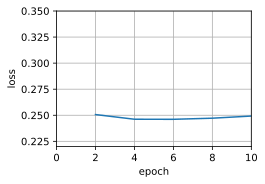

In [38]:
def train_sgd(lr, batch_size, num_epochs=2):
    data_iter, feature_dim = get_data_ch11(batch_size)
    return train_ch11(
        sgd, None, {'lr': lr}, data_iter, feature_dim, num_epochs)

gd_res = train_sgd(1, 1500, 10)

loss: 0.246, 0.062 sec/epoch


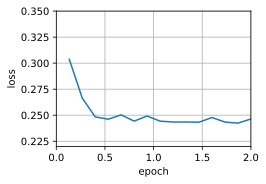

In [39]:
sgd_res = train_sgd(0.005, 1)

loss: 0.244, 0.005 sec/epoch


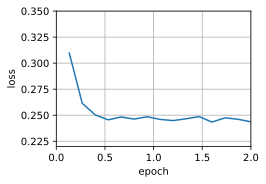

In [40]:
mini1_res = train_sgd(.4, 100)

loss: 0.247, 0.013 sec/epoch


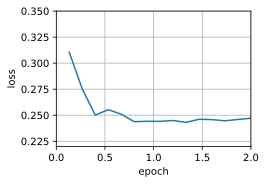

In [41]:
mini2_res = train_sgd(.05, 10)

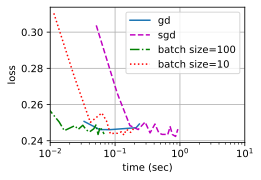

In [42]:
d2l.set_figsize([6, 3])
d2l.plot(*list(map(list, zip(gd_res, sgd_res, mini1_res, mini2_res))),
         'time (sec)', 'loss', xlim=[1e-2, 10],
         legend=['gd', 'sgd', 'batch size=100', 'batch size=10'])
d2l.plt.gca().set_xscale('log')

### Concise Implementation

In [43]:
#@save
def train_concise_ch11(trainer_fn, hyperparams, data_iter, num_epochs=4):
    # Initialization
    net = nn.Sequential(nn.Linear(5, 1))
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)

    optimizer = trainer_fn(net.parameters(), **hyperparams)
    loss = nn.MSELoss(reduction='none')
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            optimizer.zero_grad()
            out = net(X)
            y = y.reshape(out.shape)
            l = loss(out, y)
            l.mean().backward()
            optimizer.step()
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                # `MSELoss` computes squared error without the 1/2 factor
                animator.add(n/X.shape[0]/len(data_iter),
                             (d2l.evaluate_loss(net, data_iter, loss) / 2,))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')

loss: 0.242, 0.013 sec/epoch


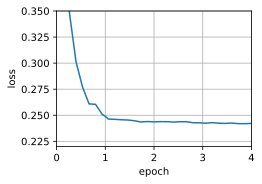

In [44]:
data_iter, _ = get_data_ch11(10)
trainer = torch.optim.SGD
train_concise_ch11(trainer, {'lr': 0.01}, data_iter)

### Summary

- Vectorization makes code more efficient due to reduced overhead arising from the deep learning framework and due to better memory locality and caching on CPUs and GPUs.

- There is a trade-off between statistical efficiency arising from stochastic gradient descent and computational efficiency arising from processing large batches of data at a time.

- Minibatch stochastic gradient descent offers the best of both worlds: computational and statistical efficiency.

- In minibatch stochastic gradient descent we process batches of data obtained by a random permutation of the training data (i.e., each observation is processed only once per epoch, albeit in random order).

- It is advisable to decay the learning rates during training.

- In general, minibatch stochastic gradient descent is faster than stochastic gradient descent and gradient descent for convergence to a smaller risk, when measured in terms of clock time.

# 11.6. Momentum

### An Ill-conditioned Problem

epoch 20, x1: -0.943467, x2: -0.000073


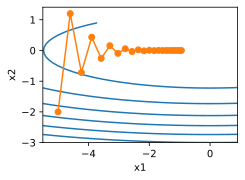

In [45]:
%matplotlib inline
import torch
from d2l import torch as d2l

eta = 0.4
def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2
def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 0.2 * x1, x2 - eta * 4 * x2, 0, 0)

d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))

epoch 20, x1: -0.387814, x2: -1673.365109


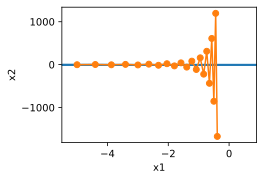

In [46]:
eta = 0.6
d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))

### The Momentum Method

epoch 20, x1: 0.007188, x2: 0.002553


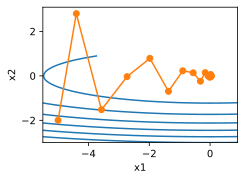

In [47]:
def momentum_2d(x1, x2, v1, v2):
    v1 = beta * v1 + 0.2 * x1
    v2 = beta * v2 + 4 * x2
    return x1 - eta * v1, x2 - eta * v2, v1, v2

eta, beta = 0.6, 0.5
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

epoch 20, x1: -0.126340, x2: -0.186632


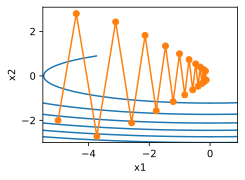

In [48]:
eta, beta = 0.6, 0.25
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

### Effective Sample Weight

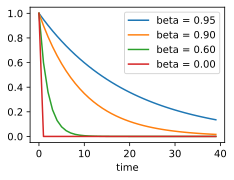

In [49]:
d2l.set_figsize()
betas = [0.95, 0.9, 0.6, 0]
for beta in betas:
    x = torch.arange(40).detach().numpy()
    d2l.plt.plot(x, beta ** x, label=f'beta = {beta:.2f}')
d2l.plt.xlabel('time')
d2l.plt.legend();

### Implementation from Scratch

In [50]:
def init_momentum_states(feature_dim):
    v_w = torch.zeros((feature_dim, 1))
    v_b = torch.zeros(1)
    return (v_w, v_b)

def sgd_momentum(params, states, hyperparams):
    for p, v in zip(params, states):
        with torch.no_grad():
            v[:] = hyperparams['momentum'] * v + p.grad
            p[:] -= hyperparams['lr'] * v
        p.grad.data.zero_()

loss: 0.243, 0.013 sec/epoch


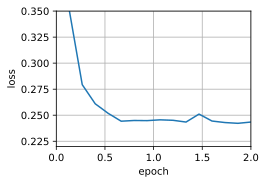

In [51]:
def train_momentum(lr, momentum, num_epochs=2):
    d2l.train_ch11(sgd_momentum, init_momentum_states(feature_dim),
                   {'lr': lr, 'momentum': momentum}, data_iter,
                   feature_dim, num_epochs)

data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
train_momentum(0.02, 0.5)

loss: 0.252, 0.015 sec/epoch


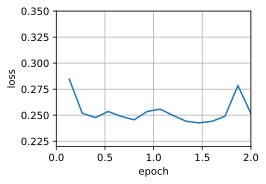

In [52]:
train_momentum(0.01, 0.9)

loss: 0.243, 0.013 sec/epoch


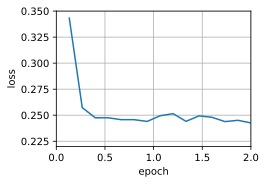

In [53]:
train_momentum(0.005, 0.9)

### Concise Implementation

loss: 0.256, 0.015 sec/epoch


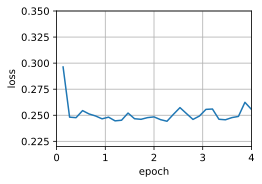

In [54]:
trainer = torch.optim.SGD
d2l.train_concise_ch11(trainer, {'lr': 0.005, 'momentum': 0.9}, data_iter)

### Scalar Functions

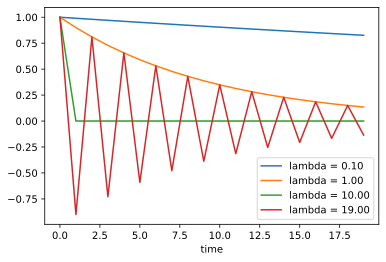

In [55]:
lambdas = [0.1, 1, 10, 19]
eta = 0.1
d2l.set_figsize((6, 4))
for lam in lambdas:
    t = torch.arange(20).detach().numpy()
    d2l.plt.plot(t, (1 - eta * lam) ** t, label=f'lambda = {lam:.2f}')
d2l.plt.xlabel('time')
d2l.plt.legend();

### Summary

- Momentum replaces gradients with a leaky average over past gradients. This accelerates convergence significantly.

- It is desirable for both noise-free gradient descent and (noisy) stochastic gradient descent.

- Momentum prevents stalling of the optimization process that is much more likely to occur for stochastic gradient descent.

- The effective number of gradients is given by 1/(1-beta) due to exponentiated downweighting of past data.

- In the case of convex quadratic problems this can be analyzed explicitly in detail.

- Implementation is quite straightforward but it requires us to store an additional state vector (momentum v).